In [2]:
from collections import Counter
import urllib
import codecs
import nltk
import numpy as np 

import pandas as pd

#downloading the webpage
import requests
import datetime

#parsing a page
from bs4 import BeautifulSoup
import re
#presentation handling
from pptx import Presentation

#file handling
from os import listdir

#WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Translator
from googletrans import Translator

import string

## Plan
1. Mieć czysty zestaw danych
2. Tokenizacja
3. Czyszczenie

#### Inicjalizacja pd.DataFrame dla piosenek

In [3]:
df_p = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Tytuł","Tekst"])
df_p.head()

,Tytuł,Tekst


In [4]:
def parse_presentation(presentation_path):
    prs = Presentation(presentation_path)
    text = str()
    for slide in prs.slides:
        for shape in slide.shapes:
            if not shape.has_text_frame:
                continue
            for paragraph in shape.text_frame.paragraphs:
                for run in paragraph.runs:
                    text = text + run.text + ' '
    return text

In [5]:
i=0
for file in listdir('prezentacje'):
    path = 'prezentacje/' + file
    song_name = file[:-5]
    text = parse_presentation(path)
    df_p.loc[i] = [song_name, text]
    i=i+1

In [6]:
i

187

In [7]:
path = 'prezentacje/Abba Ojcze.pptx'
parse_presentation(path)

'Ty wyzwoliłeś nas Panie  z kajdan i samych siebie,  a Chrystus stając się bratem  nauczył nas wołać do Ciebie:  Abba Ojcze! Abba Ojcze! Abba Ojcze! 2. Bo Kościół jak drzewo życia w wieczności zapuszcza korzenie, przenika naszą codzienność i pokazuje nam Ciebie. Abba Ojcze! Abba Ojcze! Abba Ojcze! 3. Bóg hojnym Dawcą jest życia, on wyswobodził nas z śmierci i przygarniając do siebie uczynił swoimi dziećmi. Abba Ojcze! Abba Ojcze! Abba Ojcze! 4. Wszyscy jesteśmy braćmi, jesteśmy jedną rodziną. Tej prawdy nic już nie zaćmi i teraz jest jej godzina. Abba Ojcze! Abba Ojcze! Abba Ojcze! '

In [8]:
df_p.head()

,Tytuł,Tekst
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...
1,Alleluja (Niech zabrzmi Panu),"Ref. Alleluja, Alleluja, Alleluja, Alleluja. ..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Ref. Alleluja, Alleluja, Amen, Amen, Alleluja..."
3,"Blisko, blisko, blisko jesteś","1. Blisko, blisko, blisko Jesteś Panie mój Bli..."
4,Bo góry mogą ustąpić,1. Bo góry mogą ustąpić i pagórki się zachwiać...


## Czytania danego dnia

In [9]:
#czytanie na dziś
now = datetime.datetime.now()
today = datetime.date.today()
year = str(now.year)
month = str(now.month)
if len(month) == 1:
    month = "0" + month

day = str(now.day)
if len(day) == 1:
    day = "0" + day

ymd = year+month+day
today_name = now.strftime("%A")
day_name = today_name
#today_name = 'Sunday'

address = "http://mateusz.pl/czytania/" + year + "/" + ymd + ".html"
#address = "http://mateusz.pl/czytania/2018/20181021.html" #niedziela

#print(address)

In [10]:
today_name

'Monday'

In [11]:
def get_adresses(n):
    adresses = []
    date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
    dates_cleaned = [str(x).replace('-','') for x in date_list]
    for date in dates_cleaned:
        ymd = date
        address = "http://mateusz.pl/czytania/" + ymd[:4]+ "/" + ymd + ".html"
        adresses.append(address)
    return adresses

In [12]:
#get_adresses(5)

In [13]:
def get_readings(address, day_name):
    page = requests.get(address)
    soup = BeautifulSoup(page.content, 'html.parser')
    #print(soup.prettify()) 
    #Exception handling for more readings
    try:
        #section = list(soup.children)[9]
        #section_content = section.find_all('p')   
        section = list(soup.children)
        section_content1 = section[2].find_all('p')
        if day_name == 'Sunday':
            section_content2 = section[6]
            section_content3 = section[8]
            section_content4 = section[12]
        else:
            section_content2 = None
            section_content3 = section[4]
            section_content4 = section[8]
            
        pierwsze_czytanie = str(section_content1[6])
        drugie_czytanie = str(section_content2)
        tekst_przed_ewangelia = str(section_content3)
        psalm_ref = str(section_content1[7])
        psalm = ""
        i = 8
        while i < len(section_content1):
            psalm += str(section_content1[i])
            i += 1
        ewangelia = str(section_content4)
        document = [pierwsze_czytanie,psalm_ref,psalm, drugie_czytanie, tekst_przed_ewangelia, ewangelia]
        return document
    except:
        pass
        section = soup.find_all('section')[0]
        section_content =section.find_all('p')

#### Inicjalizacja pd.DataFrame dla czytań

In [21]:
df_raw = pd.DataFrame(data=None, index=None, #pd.date_range('1/1/2019', periods=10, freq='D'), 
                  columns = ["Dzień tygodnia","Pierwsze czytanie", "Psalm_ref", "Psalm", "Drugie czytanie", 
                                                    "Werset przed Ewangelią", "Ewangelia"])
df_raw.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia


## Noise removal // Cleaning

In [234]:
#first phase - for easy reading
def clean_html(raw):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner, '', raw)
    return cleantext

def clean_proverbs (raw):
    cleaner = re.compile('\([^)]*\)')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_indent(raw):
    cleaner = re.compile('^\s+')
    cleantext = re.sub(cleaner, '',raw)
    return cleantext

def clean_rest(text):
    cleaner = re.compile('\\r\\n\s+')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_rest2(text):
    cleaner = re.compile('(\\r\\n)')
    cleantext = re.sub(cleaner, ' ',text)
    return cleantext

def clean_carriage(text):
    cleaner = re.compile('(.*)\n')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_psalmus(text):
    cleaner = re.compile('Aklamacja|REFREN\:\s|Bracia\:\s')
    cleantext = re.sub(cleaner, '',text)
    return cleantext

def clean_text(raw):
    text = clean_html(raw)
    text = clean_proverbs(text)
    text = clean_indent(text)
    text = clean_rest(text)
    text = clean_rest2(text)
    text = clean_carriage(text)
    text = clean_psalmus(text)
    return text


In [287]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [236]:
n=5
base = datetime.date.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, n)]
#print(date_list)
dates_cleaned = [str(x).replace('-','') for x in date_list]
#print(dates_cleaned)
dates_names = [x.strftime("%A") for x in date_list]
#print(dates_names)
adresses = get_adresses(n)
#print(adresses)

for i in range(n):
        doc = get_readings(adresses[i], dates_names[i])
        #doc_cleaned = [clean_text(str(text)) for text in doc]
        input_row = [dates_names[i]]
        for each in doc: #doc_cleaned:
            input_row.append(each)
        df_raw.loc[date_list[i]] = input_row



In [237]:
df_raw.head()

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-01-28,Monday,"<p>\r\n (Hbr 9, 15. 24-...","<p>\r\n (Ps 98 (97), 1b...","<p>Śpiewajcie Panu pieśń nową,<br/>\r\nalbowie...",None,<p>\r\n Aklamacja (...,"<p>\r\n (Mk 3, 22-30) <..."
2019-01-27,Sunday,"<p>\r\n (Ne 8, 2-4a. 5-...","<p>\r\n (Ps 19 (18), 8-...",<p>Prawo Pańskie jest doskonałe i pokrzepia du...,"<p>\r\n (1 Kor 12, 12-3...",<p>\r\n Aklamacja (...,"<p>\r\n (Łk 1, 1-4; 4, ..."
2019-01-26,Saturday,"<p>\r\n (Tt 1,1-5) <br/...","<p>\r\n (Ps 96,1-2.3.7-...",<p>Śpiewajcie Panu pieśń nową<br/>\r\nśpiewaj ...,None,<p>\r\n Aklamacja (...,"<p>\r\n (Łk 10, 1-9) <b..."
2019-01-25,Friday,"<p>\r\n (Dz 22, 3-16) <...","<p>\r\n (Ps 117, 1-2) <...","<p>Chwalcie Pana, wszystkie narody,<br/>\r\nwy...",None,<p>\r\n Aklamacja (...,"<p>\r\n (Mk 16, 15-18) ..."
2019-01-24,Thursday,"<p>\r\n (Hbr 7, 25 – 8,...","<p>\r\n (Ps 40 (39), 7-...",<p>Nie chciałeś ofiary krwawej ani z płodów zi...,None,<p>\r\n Aklamacja (...,"<p>\r\n (Mk 3, 7-12) <b..."


In [238]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 2019-01-28 to 2019-01-24
Data columns (total 7 columns):
Dzień tygodnia            5 non-null object
Pierwsze czytanie         5 non-null object
Psalm_ref                 5 non-null object
Psalm                     5 non-null object
Drugie czytanie           5 non-null object
Werset przed Ewangelią    5 non-null object
Ewangelia                 5 non-null object
dtypes: object(7)
memory usage: 480.0+ bytes


In [240]:
df_cleaned = df_raw.copy()

In [241]:
for each in df_cleaned.columns:
    df_cleaned[each] = df_cleaned[each].apply(lambda x: clean_text(x))

In [242]:
df_cleaned

,Dzień tygodnia,Pierwsze czytanie,Psalm_ref,Psalm,Drugie czytanie,Werset przed Ewangelią,Ewangelia
2019-01-28,Monday,"Chrystus jest pośrednikiem Nowego Przymierza, ...","Śpiewajcie Panu, bo uczynił cuda","Śpiewajcie Panu pieśń nową, albowiem uczynił c...",None,"Nasz Zbawiciel, Jezus Chrystus, śmierć zwyci...","Uczeni w Piśmie, którzy przyszli z Jerozolimy,..."
2019-01-27,Sunday,Kapłan Ezdrasz przyniósł Prawo przed zgromadze...,"Słowa Twe, Panie, są duchem i życiem",Prawo Pańskie jest doskonałe i pokrzepia duszę...,"Podobnie jak jedno jest ciało, choć składa się...","Pan posłał Mnie, abym ubogim niósł dobrą now...",Wielu już starało się ułożyć opowiadanie o zda...
2019-01-26,Saturday,"Paweł, sługa Boga i apostoł Jezusa Chrystusa, ...",Głoście cześć Pana wśród wszystkich narodów,"Śpiewajcie Panu pieśń nową śpiewaj Panu, ziemi...",None,"Pan posłał Mnie, abym ubogim głosił dobrą no...",Następnie wyznaczył Pan jeszcze innych siedemd...
2019-01-25,Friday,"Paweł powiedział do ludu: ""Ja jestem Żydem, ur...",Idźcie i głoście światu Ewangelię,"Chwalcie Pana, wszystkie narody, wysławiajcie ...",None,"Nie wyście Mnie wybrali, ale Ja was wybrałem...",Po swoim zmartwychwstaniu Jezus ukazał się Jed...
2019-01-24,Thursday,"Jezus może całkowicie zbawiać na wieki tych, k...","Przychodzę, Boże, pełnić Twoją wolę",Nie chciałeś ofiary krwawej ani z płodów ziemi...,None,"Nasz Zbawiciel, Jezus Chrystus, śmierć zwyci...",Jezus oddalił się ze swymi uczniami w stronę j...


In [255]:
doc = df_cleaned.loc[today]
pierwsze_czytanie = doc[1]
psalm_ref = doc[2]
psalm = doc[3]
drugie_czytanie = doc[4]
werset = doc[5]
ewangelia = doc[6]

In [266]:
text = doc[6]
print(text)

Uczeni w Piśmie, którzy przyszli z Jerozolimy, mówili o Jezusie: "Ma Belzebuba i mocą władcy złych duchów wyrzuca złe duchy". Wtedy Jezus przywołał ich do siebie i mówił im w przypowieściach: "Jak może Szatan wyrzucać Szatana? Jeśli jakieś królestwo jest wewnętrznie skłócone, takie królestwo nie może się ostać. I jeśli dom wewnętrznie jest skłócony, to taki dom nie będzie mógł się ostać. Jeśli więc Szatan powstał przeciw sobie i jest z sobą skłócony, to nie może się ostać, lecz koniec z nim. Nikt nie może wejść do domu mocarza i sprzęt mu zagrabić, jeśli mocarza wpierw nie zwiąże, i dopiero wtedy dom jego ograbi. Zaprawdę, powiadam wam: Wszystkie grzechy i bluźnierstwa, których by się ludzie dopuścili, będą im odpuszczone. Kto by jednak zbluźnił przeciw Duchowi Świętemu, nigdy nie otrzyma odpuszczenia, lecz winien jest grzechu wiecznego". Mówili bowiem: "Ma ducha nieczystego".


### Tłumaczenie

In [267]:
translator = Translator()
t = translator.translate(text)

In [268]:
t.text

'The scribes who came from Jerusalem spoke of Jesus: "He has Beelzebub and casts out evil spirits by the power of the ruler of evil spirits." Then Jesus called them to them and told them in the parables, "How can Satan cast out Satan?" If a kingdom is inwardly quarreled, such a kingdom can not stand, and if a house is divided against itself, then such a house will not be able to stand. therefore Satan stood against himself and is divided against himself, he can not stand, but end with him, no one can enter a strong man\'s house and rob him, if he does not bind him first, and then he will plunder his house. to you: All sins and blasphemies that would be committed by people will be forgiven them, but whoever would blaspheme against the Holy Spirit will never receive remission, but he must be eternal. " For they said: "He has an unclean spirit."'

In [286]:
text = t.text

## Tokenization & Segmentation

In [288]:
sentences = nltk.sent_tokenize(text)
sentences[:5]

['The scribes who came from Jerusalem spoke of Jesus: "He has Beelzebub and casts out evil spirits by the power of the ruler of evil spirits."',
 'Then Jesus called them to them and told them in the parables, "How can Satan cast out Satan?"',
 'If a kingdom is inwardly quarreled, such a kingdom can not stand, and if a house is divided against itself, then such a house will not be able to stand.',
 "therefore Satan stood against himself and is divided against himself, he can not stand, but end with him, no one can enter a strong man's house and rob him, if he does not bind him first, and then he will plunder his house.",
 'to you: All sins and blasphemies that would be committed by people will be forgiven them, but whoever would blaspheme against the Holy Spirit will never receive remission, but he must be eternal. "']

In [275]:
tokens = nltk.word_tokenize(text)
lower_tokens = [t.lower() for t in tokens]
print(lower_tokens)

['the', 'scribes', 'who', 'came', 'from', 'jerusalem', 'spoke', 'of', 'jesus', ':', '``', 'he', 'has', 'beelzebub', 'and', 'casts', 'out', 'evil', 'spirits', 'by', 'the', 'power', 'of', 'the', 'ruler', 'of', 'evil', 'spirits', '.', "''", 'then', 'jesus', 'called', 'them', 'to', 'them', 'and', 'told', 'them', 'in', 'the', 'parables', ',', '``', 'how', 'can', 'satan', 'cast', 'out', 'satan', '?', "''", 'if', 'a', 'kingdom', 'is', 'inwardly', 'quarreled', ',', 'such', 'a', 'kingdom', 'can', 'not', 'stand', ',', 'and', 'if', 'a', 'house', 'is', 'divided', 'against', 'itself', ',', 'then', 'such', 'a', 'house', 'will', 'not', 'be', 'able', 'to', 'stand', '.', 'therefore', 'satan', 'stood', 'against', 'himself', 'and', 'is', 'divided', 'against', 'himself', ',', 'he', 'can', 'not', 'stand', ',', 'but', 'end', 'with', 'him', ',', 'no', 'one', 'can', 'enter', 'a', 'strong', 'man', "'s", 'house', 'and', 'rob', 'him', ',', 'if', 'he', 'does', 'not', 'bind', 'him', 'first', ',', 'and', 'then', 'h

## Normalization / Preprocessing

#### Lemmatyzacja (lemmatisation) 
Algorytm znajdowania lemmy, formy podstawowej wyrazu w obszarze części mowy którą reprezentuje. Inaczej: wyszukiwanie formy kanonicznej leksemu. W komputerowej analizie języka naturalnego lemmatyzacja jest operacją bardziej precyzyjną niż stemmatyzacja. 

#### Stemmatyzacja (stemming) 
Sprowadzenie wyrazu reprezentującego dowolną część mowy do stemu, rdzenia postaci źródłowej, najczęściej rzeczownika, bądź niekiedy nawet sekwencji znaków nie mającej samodzielnego znaczenia w języku naturalnym. 

In [276]:
# Retain alphabetic words: alpha_only
alpha_only = [t for t in lower_tokens if t.isalpha()]
print(alpha_only)

['the', 'scribes', 'who', 'came', 'from', 'jerusalem', 'spoke', 'of', 'jesus', 'he', 'has', 'beelzebub', 'and', 'casts', 'out', 'evil', 'spirits', 'by', 'the', 'power', 'of', 'the', 'ruler', 'of', 'evil', 'spirits', 'then', 'jesus', 'called', 'them', 'to', 'them', 'and', 'told', 'them', 'in', 'the', 'parables', 'how', 'can', 'satan', 'cast', 'out', 'satan', 'if', 'a', 'kingdom', 'is', 'inwardly', 'quarreled', 'such', 'a', 'kingdom', 'can', 'not', 'stand', 'and', 'if', 'a', 'house', 'is', 'divided', 'against', 'itself', 'then', 'such', 'a', 'house', 'will', 'not', 'be', 'able', 'to', 'stand', 'therefore', 'satan', 'stood', 'against', 'himself', 'and', 'is', 'divided', 'against', 'himself', 'he', 'can', 'not', 'stand', 'but', 'end', 'with', 'him', 'no', 'one', 'can', 'enter', 'a', 'strong', 'man', 'house', 'and', 'rob', 'him', 'if', 'he', 'does', 'not', 'bind', 'him', 'first', 'and', 'then', 'he', 'will', 'plunder', 'his', 'house', 'to', 'you', 'all', 'sins', 'and', 'blasphemies', 'that'

In [279]:
polish_stops = codecs.open("polishStopWords",'r','utf-8')
stopwords = nltk.corpus.stopwords.words('english')
#stopwords = polish_stops.read().split('\n')
polish_stops.close()

In [280]:
# Remove all stop words: no_stops
no_stops = [t for t in alpha_only if t not in stopwords]
print(no_stops)

['scribes', 'came', 'jerusalem', 'spoke', 'jesus', 'beelzebub', 'casts', 'evil', 'spirits', 'power', 'ruler', 'evil', 'spirits', 'jesus', 'called', 'told', 'parables', 'satan', 'cast', 'satan', 'kingdom', 'inwardly', 'quarreled', 'kingdom', 'stand', 'house', 'divided', 'house', 'able', 'stand', 'therefore', 'satan', 'stood', 'divided', 'stand', 'end', 'one', 'enter', 'strong', 'man', 'house', 'rob', 'bind', 'first', 'plunder', 'house', 'sins', 'blasphemies', 'would', 'committed', 'people', 'forgiven', 'whoever', 'would', 'blaspheme', 'holy', 'spirit', 'never', 'receive', 'remission', 'must', 'said', 'unclean', 'spirit']


In [322]:
#z linked in
def clean_text2(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [323]:
def clean_text3(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    #text = [ps.stem(word) for word in tokens if word not in stopwords]
    return tokens

#### Stemming

In [281]:
ps = nltk.PorterStemmer()
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [282]:
print(stemming(no_stops))

['scribe', 'came', 'jerusalem', 'spoke', 'jesu', 'beelzebub', 'cast', 'evil', 'spirit', 'power', 'ruler', 'evil', 'spirit', 'jesu', 'call', 'told', 'parabl', 'satan', 'cast', 'satan', 'kingdom', 'inwardli', 'quarrel', 'kingdom', 'stand', 'hous', 'divid', 'hous', 'abl', 'stand', 'therefor', 'satan', 'stood', 'divid', 'stand', 'end', 'one', 'enter', 'strong', 'man', 'hous', 'rob', 'bind', 'first', 'plunder', 'hous', 'sin', 'blasphemi', 'would', 'commit', 'peopl', 'forgiven', 'whoever', 'would', 'blasphem', 'holi', 'spirit', 'never', 'receiv', 'remiss', 'must', 'said', 'unclean', 'spirit']


#### Lemmatizing

In [294]:
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [295]:
print(lemmatizing(no_stops))

['scribe', 'came', 'jerusalem', 'spoke', 'jesus', 'beelzebub', 'cast', 'evil', 'spirit', 'power', 'ruler', 'evil', 'spirit', 'jesus', 'called', 'told', 'parable', 'satan', 'cast', 'satan', 'kingdom', 'inwardly', 'quarreled', 'kingdom', 'stand', 'house', 'divided', 'house', 'able', 'stand', 'therefore', 'satan', 'stood', 'divided', 'stand', 'end', 'one', 'enter', 'strong', 'man', 'house', 'rob', 'bind', 'first', 'plunder', 'house', 'sin', 'blasphemy', 'would', 'committed', 'people', 'forgiven', 'whoever', 'would', 'blaspheme', 'holy', 'spirit', 'never', 'receive', 'remission', 'must', 'said', 'unclean', 'spirit']


In [296]:
txt = lemmatizing(no_stops)

### Bag of words

In [297]:
bow = Counter(txt)

In [298]:
bow.most_common(10)

[('spirit', 4),
 ('house', 4),
 ('satan', 3),
 ('stand', 3),
 ('jesus', 2),
 ('cast', 2),
 ('evil', 2),
 ('kingdom', 2),
 ('divided', 2),
 ('would', 2)]

### Word cloud

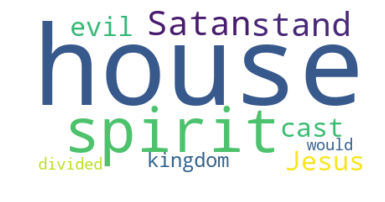

In [299]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords = stopwords, 
                      max_font_size=150, 
                      max_words=10, 
                      background_color="white").generate(clean_text(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Statystyki

#### Term frequency

In [301]:
fdist = nltk.probability.FreqDist(txt)

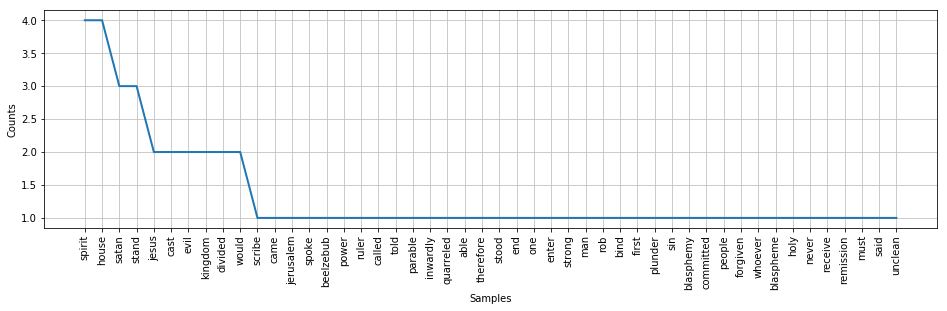

In [302]:
plt.figure(figsize=(16,4))
fdist_plot = fdist.plot()
plt.show()

In [303]:
#occurs only once
print(fdist.hapaxes())

['scribe', 'came', 'jerusalem', 'spoke', 'beelzebub', 'power', 'ruler', 'called', 'told', 'parable', 'inwardly', 'quarreled', 'able', 'therefore', 'stood', 'end', 'one', 'enter', 'strong', 'man', 'rob', 'bind', 'first', 'plunder', 'sin', 'blasphemy', 'committed', 'people', 'forgiven', 'whoever', 'blaspheme', 'holy', 'never', 'receive', 'remission', 'must', 'said', 'unclean']


In [304]:
def lexical_diversity(text):
    return len(text)/len(set(text))

def percentage(count,total):
    return 100 * count/total

In [305]:
lexical_diversity(text)

21.846153846153847

In [306]:
percentage(text.count(bow.most_common(1)[0][0]),len(text))

0.352112676056338

In [307]:
#to fix
#text.dispersion_plot(keys)

### N-Grams

In [308]:
from sklearn.feature_extraction.text import CountVectorizer

In [314]:
#PL
ngram_vect = CountVectorizer(ngram_range=(2,2))
X_counts = ngram_vect.fit_transform(df_raw['Ewangelia'].apply(lambda x: clean_text(x)))

print(X_counts.shape)
print(ngram_vect.get_feature_names()[:10])

(5, 556)
['aby czytać', 'aby go', 'aby na', 'abym obwoływał', 'abym ubogim', 'abym uciśnionych', 'abyś się', 'ale robotników', 'ani sandałów', 'ani torby']


In [315]:
#ENG
ngram_vect = CountVectorizer(ngram_range=(2,2))
X_counts = ngram_vect.fit_transform(df_raw['Ewangelia'].apply(lambda x: str(translator.translate(clean_text(x)))))

print(X_counts.shape)
print(ngram_vect.get_feature_names()[:10])

(5, 678)
['able to', 'about how', 'about the', 'absolute certainty', 'accept you', 'acted so', 'after his', 'against him', 'against himself', 'against itself']


In [316]:
#PL
ngram_vect_p = CountVectorizer(ngram_range=(2,2))
X_counts_p = ngram_vect_p.fit_transform(df_p['Tekst'])

print(X_counts_p.shape)
print(ngram_vect_p.get_feature_names()[:10])

(187, 6883)
['abba ojcze', 'abrahama izaaka', 'abrahama pomny', 'abrahama ref', 'abrahamowi jego', 'aby każdy', 'aby nami', 'aby nas', 'aby niewinnie', 'aby twój']


In [319]:
#ENG
ngram_vect_p = CountVectorizer(ngram_range=(2,2))
X_counts_p = ngram_vect_p.fit_transform(df_p['Tekst'].apply(lambda x: str(translator.translate(x))))

print(X_counts_p.shape)
print(ngram_vect_p.get_feature_names()[:10])

(187, 6569)
['abandoned home', 'abba father', 'abides in', 'able to', 'about beauty', 'about hallelujah', 'about jesus', 'about me', 'about my', 'about the']


### Tf-idf 

#### Term frequency - inverse document frequency
Ważenie częstością termów - odwrotna częstość w dokumentach - jedna z metod obliczania wagi słów w oparciu o liczbę ich wystąpień, należąca do grupy algorytmów obliczających statystyczne wagi termów. 
- Każdy dokument reprezentowany jest przez wektor, składający się z wag słów występujących w tym dokumencie. 
- TFIDF informuje o częstości wystąpienia termów uwzględniając jednocześnie odpowiednie wyważenie znaczenia lokalnego termu i jego znaczenia w kontekście pełnej kolekcji dokumentów. 

https://pl.wikipedia.org/wiki/TFIDF

- Pozwala na określenie rzadkich, ale ważnych słów każdym dokumencie

$$w(i,j) = tf(i,j) * log(\frac{N}{df(i)})$$

gdzie:

>* w(i,f) - waga tokenu i w dokumencie j
>* tf(i,j) - liczba wystąpień tokenu i w dokumencie j
>* df(i) - licza dokumentów zawierających token i
>*N - liczba wszystkich dokumentów

In [320]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [324]:
#PL
tfidf_vect = TfidfVectorizer(analyzer=clean_text3)
X_tfidf = tfidf_vect.fit_transform(df_raw['Ewangelia'].apply(lambda x: clean_text(x)))
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names()[:10])

(5, 404)
['5', 'A', 'Belzebuba', 'Boże', 'Boży', 'Duch', 'Ducha', 'Duchowi', 'Dziś', 'Ewangelię']


In [325]:
X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
X_tfidf_df.columns = tfidf_vect.get_feature_names()
X_tfidf_df

,5,A,Belzebuba,Boże,Boży,Duch,Ducha,Duchowi,Dziś,Ewangelię,...,złych,łaski,łódka,Świętemu,świadkami,świat,Żniwo,żeby,żniwa,żniwo
0,0.000000,0.000000,0.072116,0.000000,0.000000,0.000000,0.000000,0.072116,0.000000,0.000000,...,0.072116,0.000000,0.000000,0.072116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.069782,0.069782,0.000000,0.069782,0.000000,...,0.000000,0.069782,0.000000,0.000000,0.069782,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.075682,0.000000,0.000000,0.075682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075682,0.061060,0.075682,0.075682
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.111422,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.091603,0.000000,0.000000,0.091603,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.091603,0.000000,0.000000,0.000000,0.000000,0.147809,0.000000,0.000000


In [328]:
tfidf_vect_eng = TfidfVectorizer(analyzer=clean_text3)
X_tfidf_eng = tfidf_vect_eng.fit_transform(df_raw['Ewangelia'].apply(lambda x: str(translator.translate(clean_text(x)))))
print(X_tfidf_eng.shape)
print(tfidf_vect_eng.get_feature_names()[:10])

(5, 341)
['A', 'All', 'Also', 'And', 'At', 'Beelzebub', 'But', 'Even', 'For', 'Galilee']
